In [1]:
# standard python utilities
import os
import glob
import sys
import pandas as pd
import numpy as np
import calendar
import time

# standard python plotting utilities
import matplotlib as mpl
import matplotlib.pyplot as plt

# standard geospatial python utilities
import pyproj # for converting proj4string
import shapely
import geopandas as gpd
import rasterio

# mapping utilities
import contextily as ctx
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm

In [2]:
doc_dir = os.getcwd()
while os.path.basename(doc_dir) != 'Documents':
    doc_dir = os.path.dirname(doc_dir)
# dir of all gwfm data
gwfm_dir = os.path.dirname(doc_dir)+'/Box/research_cosumnes/GWFlowModel'
gwfm_dir
ghb_dir = gwfm_dir+'/GHB_data'

In [3]:
# Original model domain, 44.7 deg angle
# m_domain = gpd.read_file(gwfm_dir+'\\GWModelDomain_UTM10N\\GWModelDomain_Rec_UTM10N.shp')
# New model domain 52.9 deg
m_domain = gpd.read_file(gwfm_dir+'\\NewModelDomain\\GWModelDomain_52_9deg_UTM10N_WGS84.shp')

In [52]:
# m_domain = m_domain.to_crs('epsg:3310')

<AxesSubplot:>

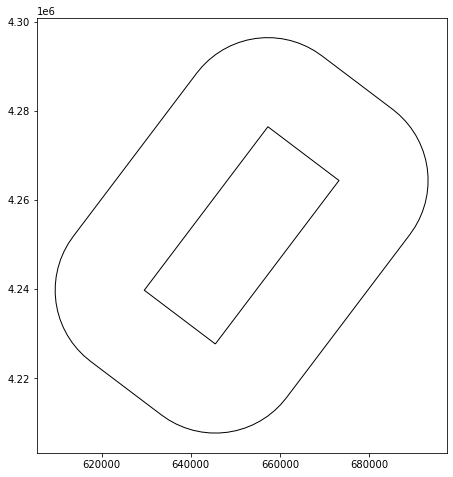

In [4]:
fig,ax= plt.subplots(figsize =(8,8))
m_domain.plot(ax=ax,edgecolor = 'black', color = 'none')
buffer = 2e4

# buffer domain in order to include boundary observations to influence water table elevations at the model edge
domain_buffered = gpd.GeoDataFrame(data = m_domain.copy(), geometry = m_domain.buffer(buffer))
domain_buffered.plot(ax=ax,edgecolor = 'black', color = 'none')


In [61]:
f2013_dwr = gpd.read_file(ghb_dir+'/Fall_Spring_Elevation_Points/Fall_2013_Elevation_Points/F2013_WSEL_Points_20150720_090332.shp')
f2013 = gpd.read_file(ghb_dir+'/Fall_Spring_GWE_Points/fall2013_GWE_Points.shp')

f2013_dwr = f2013_dwr.to_crs('epsg:32610')
f2013 = f2013.to_crs('epsg:32610')

<AxesSubplot:>

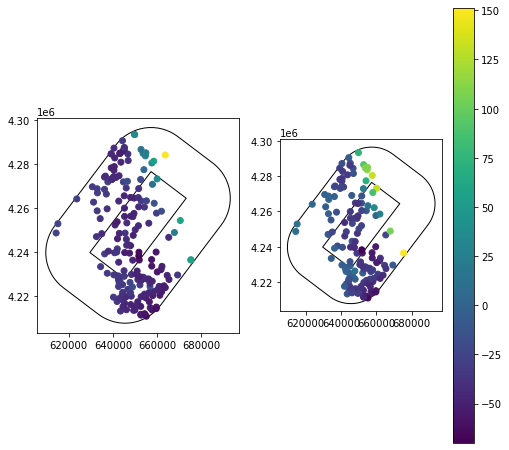

In [67]:
fig,ax= plt.subplots(1,2,figsize =(8,8))
for n in [0,1]:
    m_domain.plot(ax=ax[n],edgecolor = 'black', color = 'none')
    domain_buffered.plot(ax=ax[n],edgecolor = 'black', color = 'none')

f2013_dwr = gpd.sjoin(f2013_dwr,domain_buffered, op = 'within', how = 'inner')
# f2013.plot('WSEL', ax=ax, legend = True)
f2013.plot('GWE', ax=ax[0], legend = False)
f2013_dwr.plot('WSEL', ax=ax[1], legend = True)
# fig.tight_layout()

In [126]:
230*200/5000

9.2

<AxesSubplot:>

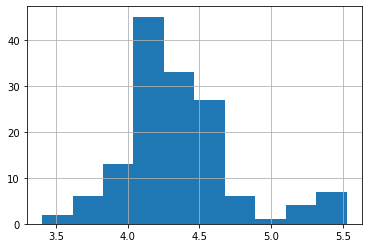

In [9]:
# f2013.WSEL.hist()
# scale by 100 to make all positive values
f2013['logWSEL'] = np.log(f2013.WSEL.values+100)
f2013.logWSEL.hist()

In [16]:
import pykrige.kriging_tools as kt
from pykrige.ok import OrdinaryKriging
from rasterio.transform import Affine


In [124]:
# define function to interpolate/krige water surface elevations
# part 1/2
def lin_krige(filename, domain_buffered, res, season,year,z_name):
    # filename of shapefiles with water surface elevation points
    # m_domain shapefile to clip grid
    # raster resolution for kriging and output
    
    # Kriging set up
    df = gpd.read_file(filename)
    df = df.to_crs('epsg:32610')
    # remove NA values
    df=df.dropna(subset=[z_name])
    
    df = gpd.sjoin(df,domain_buffered, op = 'within', how = 'inner')

    x_in = df.geometry.x.values
    y_in = df.geometry.y.values
    z_in = df[z_name].values
    res = 100
    gridx = np.arange(np.min(x_in), np.max(x_in), res)
    gridy = np.arange(np.min(y_in), np.max(y_in), res)
    
    # Kriging
    # linear, gaussian, spherical, exponential, hole-effect and power
    OK = OrdinaryKriging(
        x_in,
        y_in,
        z_in,
        # gaussian overweights low values causing all data to look the same, power looks okay with high lag
        # linear still seems best if I can avoid the singular matrix issue
        variogram_model="linear", 
        verbose=True,
        enable_plotting=True,
    #     exact_values = False,
        enable_statistics = True,
        nlags = 50, # if lags is too low, then higher values seem to dominate?
        pseudo_inv=True
    )

    
    # z is the kriged grid and ss is the variance grid (sigma ^2)
    z, ss = OK.execute("grid", gridx, gridy)
    # flip data because np sets 0,0 in top left while raster is bottom left
    Z  = np.flip(z.data,axis = 0)
    SS = np.flip(ss.data,axis = 0)

    transform = Affine.translation(np.min(x_in) - res / 2, np.max(y_in) - res / 2) * Affine.scale(res, -res)
    
    # Output file creation
    new_dataset1 = rasterio.open(ghb_dir+'/interpolated_data/'+season +str(year)+'_kriged.tif',
                           'w',driver = 'GTiff',
                           height=Z.shape[0], width = Z.shape[1],
                           count = 1, dtype = Z.dtype,
                           crs = df.crs,
                           transform = transform)

    new_dataset1.write(Z,1)
    new_dataset1.close()

    new_dataset2 = rasterio.open(ghb_dir+'/interpolated_data/'+season+str(year)+'_variance.tif',
                               'w',driver = 'GTiff',
                               height=Z.shape[0], width = Z.shape[1],
                               count = 1, dtype = Z.dtype,
                               crs = df.crs,
                               transform = transform)

    new_dataset2.write(SS,1)
    new_dataset2.close()

## Kriging with shapefiles from DWR periodic database

In [88]:

def load_gwe_pts(y,s):
    name = s+str(y)
    fn = ghb_dir+'/Fall_Spring_GWE_Points/'+name+'_GWE_Points.shp'
    df = gpd.read_file(fn)
    df = df.to_crs('epsg:32610')
    df = df.dropna(subset=['GWE'])
#     df = df.loc[:,]
    return(df)

# spring2020 = load_gwe_pts(2020,'spring')
# spring2020.plot('GWE')

# fall2019 = load_gwe_pts(2019,'fall')
# fall2019.plot('GWE')

diff = fall2019.loc[:,['SITE_CODE','GWE','month']].join(spring2020.set_index('SITE_CODE'),
                                                            on='SITE_CODE',rsuffix='s20')
diff['gwe_diff'] = diff.GWEs20 - diff.GWE
# diff.gwe_diff.plot()
# diff.plot('gwe_diff',legend=True)

diff.gwe_diff.mean()

2.526251893939394

In [129]:
for y in np.arange(2010,2022):
    for s in ['spring','fall']:
        df = load_gwe_pts(y,s)
        print(s+' '+str(y)+' mean GWE (m) '+ str(df.GWE.mean()))


spring 2010 mean GWE (m) -12.01980952380952
fall 2010 mean GWE (m) -13.306941919191921
spring 2011 mean GWE (m) -4.993750000000003
fall 2011 mean GWE (m) -9.436157601115749
spring 2012 mean GWE (m) -5.018325892857139
fall 2012 mean GWE (m) -10.342528223410591
spring 2013 mean GWE (m) -7.808906390639061
fall 2013 mean GWE (m) -10.146341880341867
spring 2014 mean GWE (m) -4.853994102228051
fall 2014 mean GWE (m) -4.246021978021985
spring 2015 mean GWE (m) 8.510319816053512
fall 2015 mean GWE (m) -2.329138233054069
spring 2016 mean GWE (m) 4.47436471688034
fall 2016 mean GWE (m) 3.3089230769230693
spring 2017 mean GWE (m) 7.474266955266955
fall 2017 mean GWE (m) 8.302961758241757
spring 2018 mean GWE (m) 15.663368855218854
fall 2018 mean GWE (m) -14.739106357864337
spring 2019 mean GWE (m) 14.82952777777777
fall 2019 mean GWE (m) 9.970563232830818
spring 2020 mean GWE (m) 8.935958937198063
fall 2020 mean GWE (m) 6.897129834254146
spring 2021 mean GWE (m) 15.705334331337326
fall 2021 mean 

Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'linear' Variogram Model
Slope: 0.06790725747475569
Nugget: 1.712884729900215e-14 



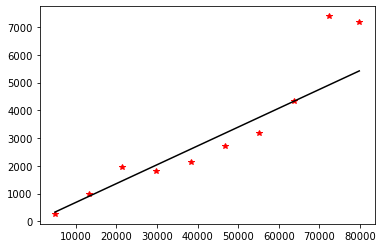

Calculating statistics on variogram model fit...


<string>:6: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.


Q1 = 0.13019919452066536
Q2 = 2.250544603085352
cR = 485.8277022910161 

Executing Ordinary Kriging...



In [117]:
s='spring'
y=2014

name = s+str(y)
fn = ghb_dir+'/Fall_Spring_GWE_Points/'+name+'_GWE_Points.shp'
        
df = gpd.read_file(fn)
df = df.to_crs('epsg:32610')
df = df.dropna(subset=['GWE'])
df = gpd.sjoin(df,domain_buffered, op = 'within', how = 'inner')
x_in = df.geometry.x.values
y_in = df.geometry.y.values
z_in = df['GWE'].values
res = 100
gridx = np.arange(np.min(x_in), np.max(x_in), res)
gridy = np.arange(np.min(y_in), np.max(y_in), res)

# Kriging
# linear, gaussian, spherical, exponential, hole-effect and power
OK = OrdinaryKriging(
    x_in,
    y_in,
    z_in,
    variogram_model="linear", # use linear with high number of lags to cause more averaging
    verbose=True,
    enable_plotting=True,
#     exact_values = False,
    enable_statistics = True,
    # 20*100 = 2,000 m lag distance = fair for typical well spacing, 50 is too much for some years (not enough data)
    nlags = 10,
    pseudo_inv=True # can lead to more stability but takes longer
)
# 2014 requires nlags = 5, 2012 nlags=30, with exponential you can go farther
# z is the kriged grid and ss is the variance grid (sigma ^2)
z, ss = OK.execute("grid", gridx, gridy)
# flip data because np sets 0,0 in top left while raster is bottom left
Z_2019  = np.flip(z.data,axis = 0)
SS = np.flip(ss.data,axis = 0)



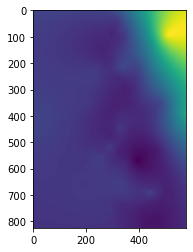

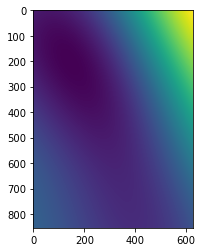

In [107]:
plt.imshow(Z_2019)
plt.show()
plt.imshow(Z_2020)

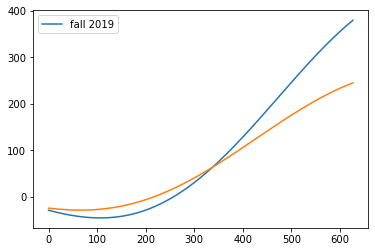

In [72]:
plt.plot(Z_2019[0,:],label='fall 2019')
plt.plot(Z_2020[0,:])
# plt.plot(Z_2019[99,:])
# plt.plot(Z_2020[99,:])
plt.legend()

In [ ]:
# Z_gauss, Z_exp, Z_power, Z_linear # cR =  757, 522, 1053, DNE

Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'linear' Variogram Model
Slope: 0.022193829283531866
Nugget: 327.91817575613203 



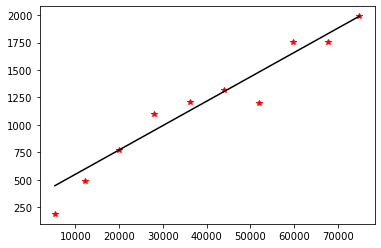

Calculating statistics on variogram model fit...
Q1 = 0.0028160764123788475
Q2 = 0.7447183839250858
cR = 367.1478339625034 

Executing Ordinary Kriging...

2010
Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'linear' Variogram Model
Slope: 0.015781916227522837
Nugget: 908.2314038630306 



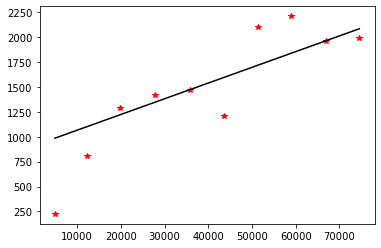

Calculating statistics on variogram model fit...
Q1 = 0.048411887917255925
Q2 = 0.7323008826437447
cR = 837.0803558410676 

Executing Ordinary Kriging...

2011
Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'linear' Variogram Model
Slope: 0.0701373184394912
Nugget: 4.26258562884088e-12 



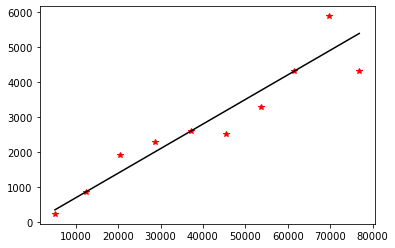

Calculating statistics on variogram model fit...
Q1 = 0.09908827323699307
Q2 = 3.8301214002556314
cR = 862.0675767198701 

Executing Ordinary Kriging...

2012
Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'linear' Variogram Model
Slope: 0.05823866341272806
Nugget: 58.79915124937078 



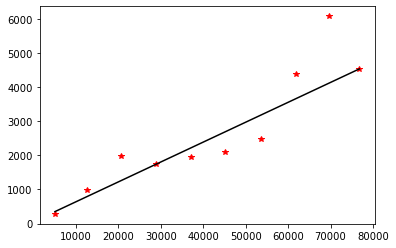

Calculating statistics on variogram model fit...
Q1 = 0.02399858117475546
Q2 = 1.0119943141874068
cR = 304.5665203863245 

Executing Ordinary Kriging...

2013
Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'linear' Variogram Model
Slope: 0.06790725747475569
Nugget: 1.712884729900215e-14 



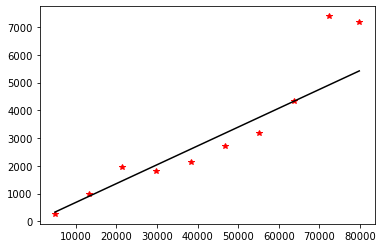

Calculating statistics on variogram model fit...


<string>:6: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.


Q1 = 0.13019919452066536
Q2 = 2.250544603085352
cR = 485.8277022910161 

Executing Ordinary Kriging...

2014
Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'linear' Variogram Model
Slope: 0.15014544612397873
Nugget: 1205.9637046822493 



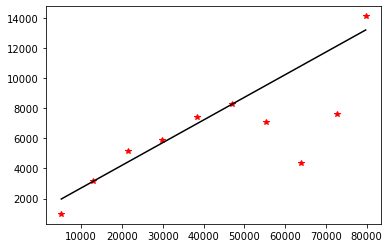

Calculating statistics on variogram model fit...
Q1 = 0.00684133926186475
Q2 = 0.43226445395149193
cR = 977.6762971583606 

Executing Ordinary Kriging...



<string>:6: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.


2015
Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'linear' Variogram Model
Slope: 0.10930516301603815
Nugget: 921.391243945501 



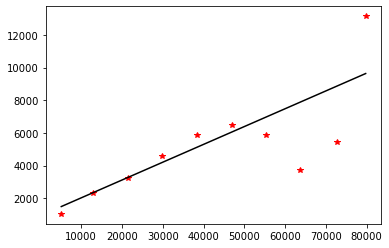

Calculating statistics on variogram model fit...


<string>:6: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.


Q1 = 0.002860180257062837
Q2 = 0.4789155986446167
cR = 808.0011664957286 

Executing Ordinary Kriging...

2016
Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'linear' Variogram Model
Slope: 0.13127616038816795
Nugget: 17.185811297432622 



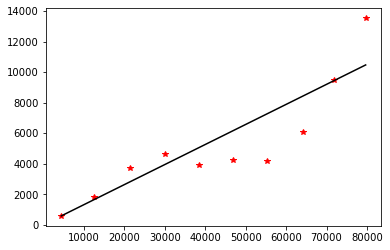

Calculating statistics on variogram model fit...


<string>:6: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.


Q1 = 0.037647383906545935
Q2 = 1.2074435232924445
cR = 515.6149787697049 

Executing Ordinary Kriging...

2017
Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'linear' Variogram Model
Slope: 0.09801641354164299
Nugget: 1431.6920274388062 



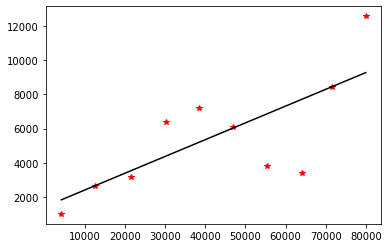

Calculating statistics on variogram model fit...
Q1 = 0.018581706816278288
Q2 = 0.5061222015373285
cR = 1121.7071894731787 

Executing Ordinary Kriging...



<string>:6: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.


2018
Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'linear' Variogram Model
Slope: 0.0989485873020966
Nugget: 1407.0554250754826 



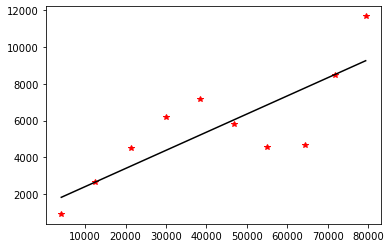

Calculating statistics on variogram model fit...
Q1 = 0.026538910665339078
Q2 = 0.5814290201258556
cR = 1282.8822599386617 

Executing Ordinary Kriging...

2019
Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'linear' Variogram Model
Slope: 0.0982566048120169
Nugget: 648.9028111974505 



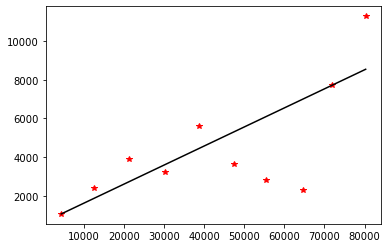

Calculating statistics on variogram model fit...
Q1 = 0.04780283584788045
Q2 = 0.7580883633976481
cR = 1019.0262589488981 

Executing Ordinary Kriging...

2020
Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'linear' Variogram Model
Slope: 0.14575243347704658
Nugget: 1067.3918369747398 



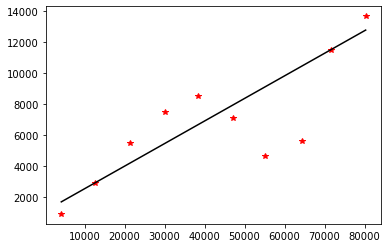

Calculating statistics on variogram model fit...
Q1 = 2027.1353689873456
Q2 = 542447356.9677837
cR = 891437202831.8926 

Executing Ordinary Kriging...

2021
Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'linear' Variogram Model
Slope: 0.002047575418471875
Nugget: 736.4288902582746 



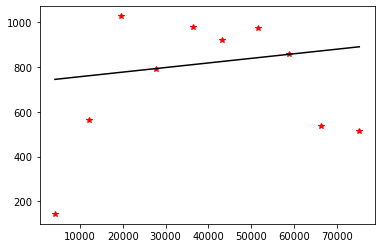

Calculating statistics on variogram model fit...
Q1 = 0.141161550780999
Q2 = 0.9890205709370203
cR = 812.4292640594896 

Executing Ordinary Kriging...

2010
Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'linear' Variogram Model
Slope: 0.02925624201640301
Nugget: 102.42964119042037 



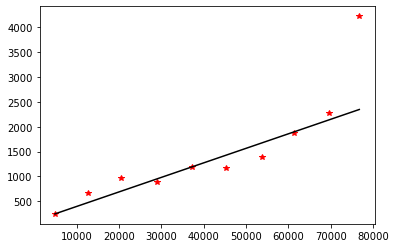

Calculating statistics on variogram model fit...
Q1 = 0.006614300911769279
Q2 = 1.034066046680004
cR = 249.40397088322322 

Executing Ordinary Kriging...

2011
Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'linear' Variogram Model
Slope: 0.06364801351502754
Nugget: 305.1012843294414 



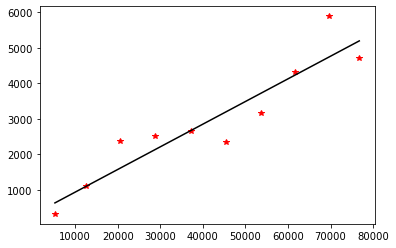

Calculating statistics on variogram model fit...
Q1 = 0.01172990577314889
Q2 = 0.7658174349167257
cR = 501.3660460183914 

Executing Ordinary Kriging...

2012
Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'linear' Variogram Model
Slope: 0.06786157634594171
Nugget: 327.9184547866293 



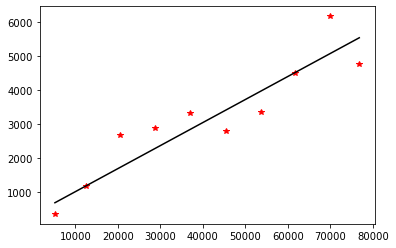

Calculating statistics on variogram model fit...
Q1 = 0.023778279753885478
Q2 = 0.7685182274138495
cR = 542.6305174175741 

Executing Ordinary Kriging...

2013
Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'linear' Variogram Model
Slope: 0.07584815057232241
Nugget: 678.4004886855174 



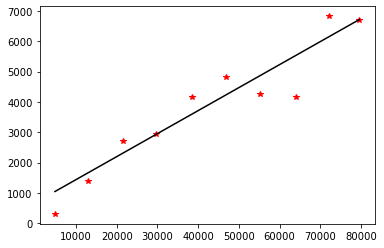

Calculating statistics on variogram model fit...


<string>:6: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.


Q1 = 0.0060401486665223195
Q2 = 0.6516372708922618
cR = 770.7239488589711 

Executing Ordinary Kriging...

2014
Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'linear' Variogram Model
Slope: 0.11149311075751908
Nugget: 341.25738135330647 



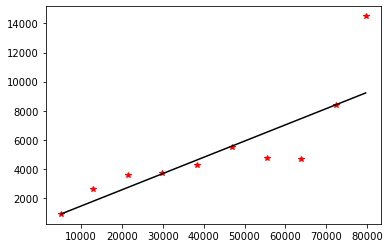

Calculating statistics on variogram model fit...


<string>:6: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.


Q1 = 0.010540042656142862
Q2 = 0.6244477080310312
cR = 584.5902429513046 

Executing Ordinary Kriging...

2015
Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'linear' Variogram Model
Slope: 0.14327493469126043
Nugget: 1032.0458152711842 



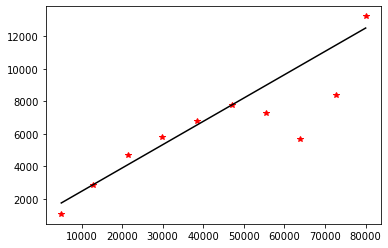

Calculating statistics on variogram model fit...
Q1 = 0.013412467020343839
Q2 = 0.4850604393825622
cR = 987.1613009970058 

Executing Ordinary Kriging...



<string>:6: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.


2016
Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'linear' Variogram Model
Slope: 0.11486684352903782
Nugget: 1213.6613156793082 



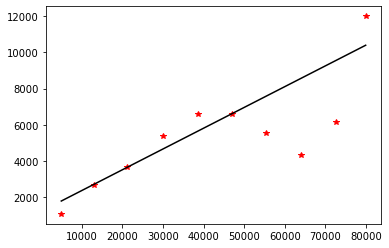

Calculating statistics on variogram model fit...
Q1 = 0.002658860366702832
Q2 = 0.47458780088256663
cR = 998.508954801151 

Executing Ordinary Kriging...



<string>:6: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.


2017
Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'linear' Variogram Model
Slope: 0.14298167339675819
Nugget: 884.5516150651816 



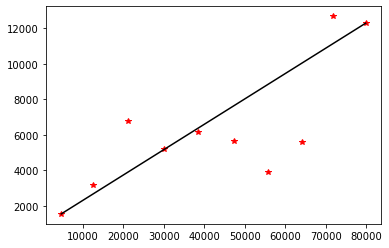

Calculating statistics on variogram model fit...


<string>:6: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.


Q1 = 0.09150165632269629
Q2 = 0.7908845883949869
cR = 1269.4946134169609 

Executing Ordinary Kriging...

2018
Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'linear' Variogram Model
Slope: 0.11673282555375547
Nugget: 954.7784585955133 



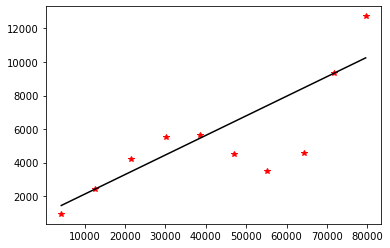

Calculating statistics on variogram model fit...
Q1 = 0.04480963912757923
Q2 = 0.6017694684213363
cR = 1039.4188892598918 

Executing Ordinary Kriging...

2019
Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'linear' Variogram Model
Slope: 0.0907112616894133
Nugget: 1165.919904828526 



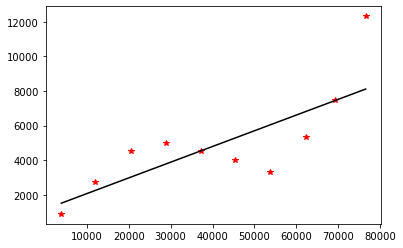

Calculating statistics on variogram model fit...
Q1 = 978.4294271667289
Q2 = 138797749.88934636
cR = 209333705038.6722 

Executing Ordinary Kriging...

2020
Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'linear' Variogram Model
Slope: 0.13033096336819963
Nugget: 1225.8549232454748 



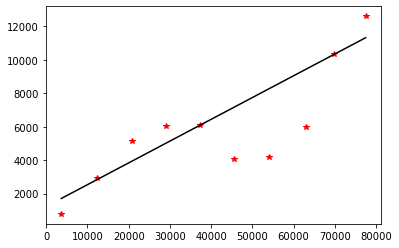

Calculating statistics on variogram model fit...
Q1 = 0.04792103817702859
Q2 = 0.5538963459058981
cR = 1215.0734257764311 

Executing Ordinary Kriging...



<string>:6: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.


2021


In [122]:
strt_year = 2010
end_year = 2022
# linear with 50 lags works from 2013:2021
for s in ['spring','fall']:
    for y in np.arange(strt_year,end_year):
        name = s+str(y)
        fn = ghb_dir+'/Fall_Spring_GWE_Points/'+name+'_GWE_Points.shp'
        lin_krige(fn, domain_buffered, res=100, season=s,year=y, z_name='GWE')
        print(y)


### Fall GWL Points to kriged data

Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'linear' Variogram Model
Slope: 0.048116054549222485
Nugget: 63.61690132030448 



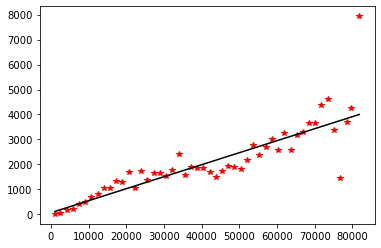

Calculating statistics on variogram model fit...
Q1 = 0.015618731068226449
Q2 = 0.9372777140345642
cR = 277.6199911246673 

Executing Ordinary Kriging...

Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'linear' Variogram Model
Slope: 0.045427368009121206
Nugget: 496.7589052265102 



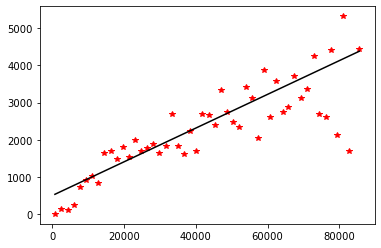

Calculating statistics on variogram model fit...
Q1 = 0.029434101707914568
Q2 = 0.8048765060656338
cR = 737.9953832487266 

Executing Ordinary Kriging...

Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'linear' Variogram Model
Slope: 0.04779283862402568
Nugget: 93.57644368959357 



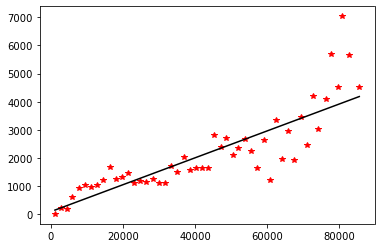

Calculating statistics on variogram model fit...
Q1 = 0.06353612914177914
Q2 = 1.1170538199193976
cR = 454.97923026827135 

Executing Ordinary Kriging...

Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'linear' Variogram Model
Slope: 0.11376216242560769
Nugget: 975.5422913736013 



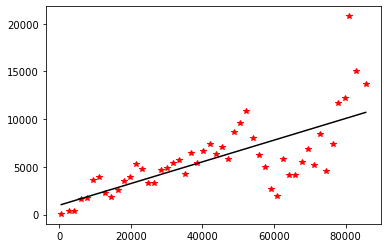

Calculating statistics on variogram model fit...
Q1 = 0.18024951224682004
Q2 = 0.5675996171562847
cR = 1077.6164252689066 

Executing Ordinary Kriging...

Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'linear' Variogram Model
Slope: 0.10566332955133542
Nugget: 1772.9130068510237 



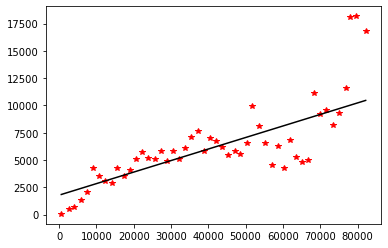

Calculating statistics on variogram model fit...
Q1 = 0.19531150956018767
Q2 = 0.5495138256346995
cR = 1570.3141047882525 

Executing Ordinary Kriging...

Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'linear' Variogram Model
Slope: 0.11032031610740932
Nugget: 1826.8364508905288 



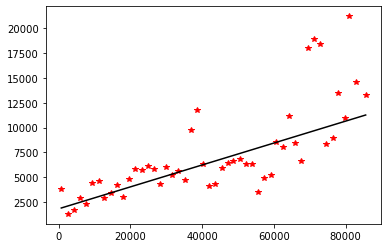

Calculating statistics on variogram model fit...
Q1 = 0.038681588732239876
Q2 = 0.5782299758649001
cR = 1604.9177999168428 

Executing Ordinary Kriging...



In [36]:
# strtyear = 2013
# endyear = 2019

# for year in np.arange(strtyear,endyear):
#     filename = glob.glob(ghb_dir+'/Fall_Spring_Elevation_Points/Fall_'+str(year)+'_Elevation_Points/*.shp')[0]
#     lin_krige(filename, domain_buffered, res=100, season='fall', z_name='WSEL')

### Spring GWL Points to kriged data

Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'linear' Variogram Model
Slope: 0.02509394797040694
Nugget: 347.92321713587216 



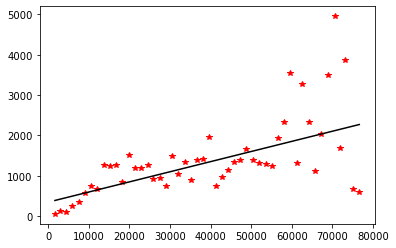

Calculating statistics on variogram model fit...
Q1 = 0.039706259952172376
Q2 = 0.7636004138461701
cR = 484.4971696626047 

Executing Ordinary Kriging...

Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'linear' Variogram Model
Slope: 0.042973493573187464
Nugget: 363.9761007590643 



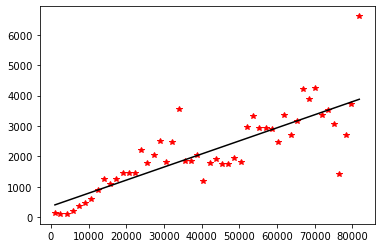

Calculating statistics on variogram model fit...
Q1 = 0.07178421311764817
Q2 = 0.7693564848527231
cR = 500.4376070790251 

Executing Ordinary Kriging...

Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'linear' Variogram Model
Slope: 0.04095242924005948
Nugget: 15.619126641413198 



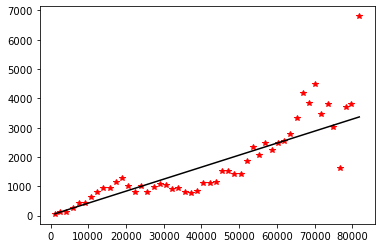

Calculating statistics on variogram model fit...
Q1 = 0.03559798707018873
Q2 = 1.144975701140815
cR = 206.53208516380084 

Executing Ordinary Kriging...

Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'linear' Variogram Model
Slope: 0.03370785969299142
Nugget: 261.57325629029384 



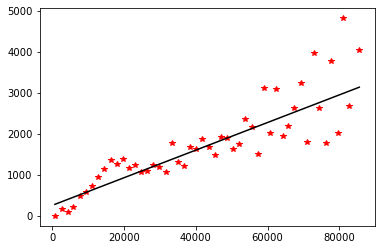

Calculating statistics on variogram model fit...
Q1 = 0.007768591455574747
Q2 = 0.9148044105056713
cR = 493.43767871005554 

Executing Ordinary Kriging...

Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'linear' Variogram Model
Slope: 0.03987119866652792
Nugget: 880.0163592135837 



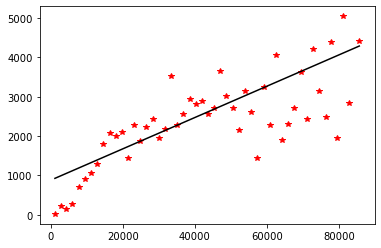

Calculating statistics on variogram model fit...
Q1 = 0.041586212585799275
Q2 = 0.6623003017590269
cR = 877.9516399977308 

Executing Ordinary Kriging...

Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'linear' Variogram Model
Slope: 0.10802926357527665
Nugget: 444.24768315994083 



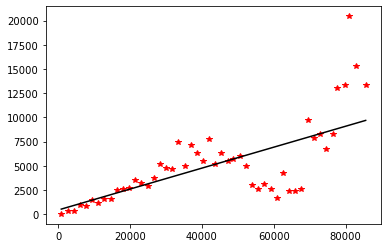

Calculating statistics on variogram model fit...
Q1 = 0.0033337669118822387
Q2 = 0.5360969096413867
cR = 529.6081761053813 

Executing Ordinary Kriging...

Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'linear' Variogram Model
Slope: 0.12151603514752922
Nugget: 957.3255399913513 



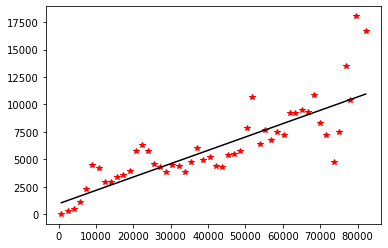

Calculating statistics on variogram model fit...
Q1 = 0.11427622985504653
Q2 = 0.614477386523136
cR = 1134.6088434119529 

Executing Ordinary Kriging...

Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'linear' Variogram Model
Slope: 0.03000701091469609
Nugget: 1564.1643799797034 



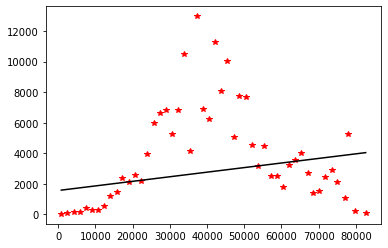

Calculating statistics on variogram model fit...
Q1 = 0.0787202077116219
Q2 = 0.9126305910782946
cR = 1812.9429404478053 

Executing Ordinary Kriging...



In [37]:
# strtyear = 2011
# endyear = 2019

# for year in np.arange(strtyear,endyear):
#     filename = glob.glob(ghb_dir+'/Fall_Spring_Elevation_Points/Spring_'+str(year)+'_Elevation_Points/*.shp')[0]
#     lin_krige(filename, domain_buffered, res=100, season = 'spring', z_name='WSEL')

## Load with flopy to crop down to domain

In [5]:
from flopy.utils import Raster
import flopy


In [6]:
xll, yll = list(m_domain.geometry.values[0].exterior.coords)[0]
#Maribeth's model parameters, had to switch nrow and ncol due to her issue in xul, yul
nrow=100
ncol=230
delr=np.repeat(200,ncol)
delc=np.repeat(200,nrow)
rotation=52.9
modelgrid = flopy.discretization.StructuredGrid(xoff=xll, yoff=yll, proj4='EPSG:32610', angrot=rotation,
                                   delr=delr, delc=delc, nrow=nrow,ncol=ncol)

In [7]:
def krige_crop(filename, season,year):
    # krige_crop, reduces the geotiff to the model domain by resampling
    # additionally it filters out the data needed just for the NW,SE BCs
    df_rio = Raster.load(filename)
    
    # 2 seconds for linear, 0.2 seconds for nearest when 200m spacing is used
    # 9 seconds for linear when 100m grid is used for kriging
    # t0 = time.time()
    df_grid = df_rio.resample_to_grid(modelgrid,
                                    band=df_rio.bands[0],
                                    method="linear")
    # resample_time = time.time() - t0
    # print("Resample time, nearest neighbor: {:.3f} sec".format(time.time() - t0))

   
    np.savetxt(ghb_dir+'/final_WSEL_arrays/'+season+str(year)+'_kriged_WSEL.tsv',
               df_grid, delimiter = '\t')

In [123]:
for s in ['spring','fall']:
    for y in np.arange(strt_year,end_year):
        name = s+str(y)
        fn = ghb_dir+'/interpolated_data/'+name+'_kriged.tif'
        krige_crop(fn, season=s,year=y)

### Fall GWL data krige to array

In [42]:
# strtyear = 2013
# endyear = 2019

# for year in np.arange(strtyear,endyear):
#     filename = glob.glob(ghb_dir+'/interpolated_data/fall'+str(year)+'_kriged.tif')[0]
#     krige_crop(filename, season = 'fall',year=y)

### Spring GWL data krige to array

In [44]:
# strtyear = 2011
# endyear = 2019
# for year in np.arange(strtyear,endyear):
#     filename = glob.glob(ghb_dir+'/interpolated_data/spring'+str(year)+'_kriged.tif')[0]
#     krige_crop(filename, season = 'spring')

In [119]:
# f2013_rio = Raster.load(ghb_dir+'/interpolated_data/f2013_kriged.tif')

In [120]:
# # 2 seconds for linear, 0.2 seconds for nearest when 200m spacing is used
# # 9 seconds for linear when 100m grid is used for kriging
# t0 = time.time()
# f2013_grid = f2013_rio.resample_to_grid(m.modelgrid,
#                                 band=f2013_rio.bands[0],
#                                 method="linear")
# resample_time = time.time() - t0
# print("Resample time, nearest neighbor: {:.3f} sec".format(time.time() - t0))

Resample time, nearest neighbor: 9.611 sec


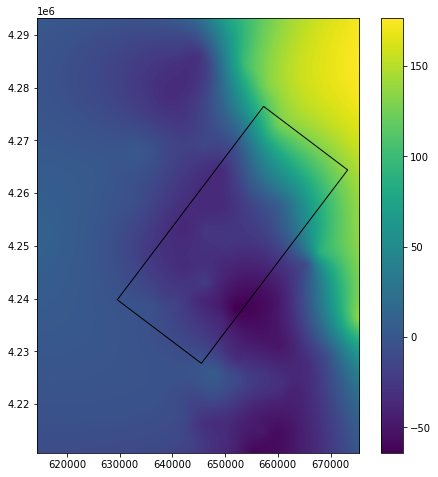

In [122]:
# ghb_dir = gwfm_dir+'/GHB_data'
# fig,ax= plt.subplots(figsize =(8,8))

# m_domain.plot(ax=ax,edgecolor = 'black', color = 'none')

# ax = f2013_rio.plot(ax=ax)
# cbar = plt.colorbar(ax.images[0])

## Geostatus Guy - Professor Michael Pyrcz version based on Deutsch and Journel 1992

In [25]:
import geostatspy.GSLIB as GSLIB                          # GSLIB utilities, viz and wrapped functions
import geostatspy.geostats as geostats                    # GSLIB converted to Python


In [42]:
f2013['x'] = f2013.geometry.x
x = f2013.x
f2013['y'] = f2013.geometry.y
y = f2013.y

z = f2013.WSEL.values
gridx = np.arange(np.min(x), np.max(x), 200)
gridy = np.arange(np.min(y), np.max(y), 200)

In [44]:
xmin = f2013.x.min()
xmax = f2013.x.max()
ymin = f2013.y.min()
ymax = f2013.y.max()

cmap = plt.cm.plasma                    # color map
gw_min = f2013.WSEL.min()
gw_max = f2013.WSEL.max()

In [33]:
f2013.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Well_Use,144.0,3.409722e+00,1.450407,1.000000e+00,3.000000e+00,3.000000e+00,4.000000e+00,7.000000e+00
Msmt_Agenc,144.0,2.985188e+03,2482.389194,1.000000e+00,1.000000e+00,5.022000e+03,5.022000e+03,5.203000e+03
WSEL,144.0,-1.516611e+01,40.220602,-6.998000e+01,-3.556500e+01,-2.625000e+01,-5.835000e+00,1.512100e+02
DGBS,144.0,8.931278e+01,45.561152,7.600000e+00,4.915000e+01,9.230000e+01,1.193500e+02,1.860000e+02
RP_Elevati,144.0,7.514847e+01,58.255344,6.500000e+00,3.274000e+01,6.075500e+01,1.058025e+02,3.144800e+02
GS_Elevati,144.0,7.414667e+01,58.141433,6.000000e+00,3.245250e+01,5.969000e+01,1.051000e+02,3.124800e+02
Msmt_Metho,144.0,1.208333e+00,0.407534,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,2.000000e+00
Msmt_Issue,144.0,6.875000e-01,2.398918,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,9.000000e+00
Latitude,144.0,3.833053e+01,0.216584,3.803230e+01,3.813705e+01,3.829060e+01,3.851597e+01,3.877554e+01
Longitude,144.0,-1.212970e+02,0.109842,-1.216916e+02,-1.213659e+02,-1.212891e+02,-1.212247e+02,-1.209949e+02


In [34]:
f2013['NWSEL'], tvWSEL, tnsWSEL = geostats.nscore(f2013, 'WSEL')

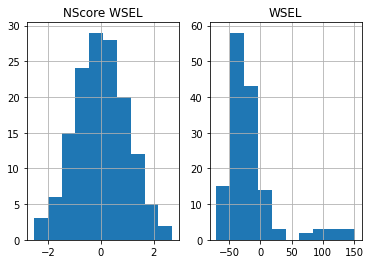

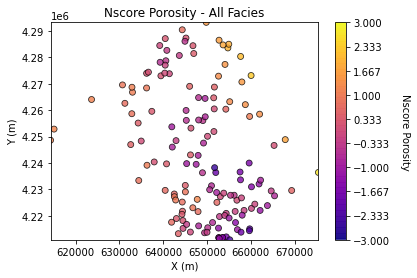

In [45]:
plt.subplot(121)
plt.title('NScore WSEL')
f2013.NWSEL.hist()
plt.subplot(122)
plt.title('WSEL')
f2013.WSEL.hist()
plt.show()

cmap = plt.cm.plasma                  
GSLIB.locmap_st(f2013,'x','y','NWSEL',xmin,xmax,ymin,ymax,-3,3,
                'Nscore Porosity - All Facies','X (m)','Y (m)','Nscore Porosity',cmap)

In [72]:
# Calculate Sample Data Isotropic Variograms
tmin = -9999.; tmax = 9999.; 
lag_dist = 100.0; lag_tol = 100.0; nlag = 50; bandh = 9999.9; azi = 0; atol = 90.0; isill = 1

lag, wsel_gamma, wsel_npair = geostats.gamv(f2013,"x","y","NWSEL",tmin,tmax,
                                                    lag_dist,lag_tol,nlag,azi,atol,bandh,isill)

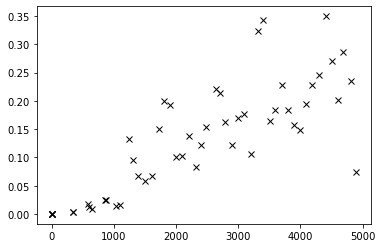

In [73]:
plt.plot(lag,wsel_gamma,'x',color = 'black',label = 'All')


In [28]:
xlen = xmax-xmin
ylen = ymax-ymin
xsiz = 100
ysiz = 100
nx = xlen/xsiz
ny = ylen/ysiz
nx = np.ceil(nx).astype(int)
ny = np.ceil(ny).astype(int)
if nx>ny:
    ny = nx
else:
    nx=ny
# readjust xmax, ymax based on nx, ny
xmax = xmin + xsiz*nx
ymax = ymin + ysiz*ny

tmin = -9999.9; tmax = 9999.9; 


In [29]:
xmin,xmax,ymin,ymax,xsiz

(614283.4123730734, 696783.4123730734, 4210874.85358532, 4293374.85358532, 100)

In [30]:
skmean_wsel = f2013.WSEL.mean()      # simple kriging mean (used if simple kriging is selected below)
ktype = 1                                  # kriging type, 0 - simple, 1 - ordinary
radius = 10000                               # search radius for neighbouring data
nxdis = 100; nydis = 100                       # number of grid discretizations for block kriging (not tested)
ndmin = 0; ndmax = 10                      # minimum and maximum data for an estimate

wsel_vario = GSLIB.make_variogram(nug=0.0,nst=1,it1=1,cc1=1.0,azi1=0,hmaj1=100,hmin1=100) # wsel variogram

In [31]:
wsel_kmap, wsel_vmap = geostats.kb2d(f2013,'x','y','WSEL',tmin,tmax,nx,xmin,xsiz,ny,ymin,ysiz,nxdis,nydis,
         ndmin,ndmax,radius,ktype,skmean_wsel,wsel_vario)

plt.subplot(211)
GSLIB.locpix_st(wsel_kmap,xmin,xmax,ymin,ymax,xsiz,-40,170,f2013,'x','y','WSEL','Kriging Estimate','X(m)','Y(m)','WSEL (m)',cmap)

plt.subplot(212)
GSLIB.pixelplt_st(wsel_vmap,xmin,xmax,ymin,ymax,xsiz,0.0,1000,'Kriging Variance','X(m)','Y(m)','WSEL $(m^2)$',cmap)

NameError: name 'real' is not defined